In [ ]:
!pip install librosa
!pip install numpy
!pip install pandas
!pip install umap-learn

import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
import umap
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import Counter
import os

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

method = 'pca'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00
Mounted at /content/gdrive


In [ ]:
gtzan_df = pd.read_csv("/content/gdrive/MyDrive/ML Final Project/features_3_sec.csv")
gtzan_df = gtzan_df.iloc[:, 2:]
# identify columns whose names end with 'var'
columns_to_transform = [col for col in gtzan_df.columns if col.endswith('var')]
# apply IHS transformation to the selected columns
gtzan_df[columns_to_transform] = np.arcsinh(gtzan_df[columns_to_transform])
gtzan_df

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.335406,0.090923,0.130405,0.003521,1773.065032,12.722134,1972.744388,12.365942,3714.560359,14.586350,...,4.374333,-3.241280,4.290325,0.722209,4.333511,-5.050335,4.208432,-0.243027,4.472267,blues
1,0.343065,0.086040,0.112699,0.001450,1816.693777,12.106536,2010.051501,11.785573,3869.682242,14.111525,...,4.863714,-6.055294,4.398977,0.159015,4.630233,-2.837699,5.268202,5.784063,4.786612,blues
2,0.346815,0.092113,0.132003,0.004620,1788.539719,12.314097,2084.565132,11.920055,3997.639160,14.273837,...,4.902906,-1.768610,4.038035,2.378768,4.515751,-1.938424,4.664487,2.517375,4.193063,blues
3,0.363639,0.086747,0.132565,0.002448,1655.289045,12.318975,1960.039988,12.018702,3568.300218,14.427071,...,4.559015,-3.841155,4.037631,1.218588,4.242136,-3.580352,4.621853,3.630866,4.159866,blues
4,0.335579,0.088015,0.143289,0.001701,1630.656199,11.978761,1948.503884,11.698642,3469.992864,14.014707,...,4.105766,0.664582,4.519315,1.689446,4.632171,-3.392489,3.979612,0.536961,4.065783,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,0.349126,0.080429,0.050019,0.000097,1499.083005,12.702395,1718.707215,12.054454,3015.559458,14.343727,...,4.442460,-9.094270,4.339468,-4.246976,4.129000,-5.625813,4.581066,1.818823,4.356026,rock
9986,0.372564,0.082532,0.057897,0.000088,1847.965128,13.239453,1906.468492,12.203339,3746.694524,14.666422,...,4.172013,-12.375726,4.889181,-3.081278,4.689858,-11.960546,4.843497,0.428857,3.622226,rock
9987,0.347481,0.088902,0.052403,0.000701,1346.157659,14.097611,1561.859087,12.533669,2442.362154,15.465273,...,5.052818,-2.524483,3.774620,4.809936,3.950876,1.775686,4.576514,-0.299545,4.421079,rock
9988,0.387527,0.084714,0.066430,0.000320,2084.515327,12.918488,2018.366254,10.730335,4313.266226,13.809267,...,4.037159,-5.363541,3.539477,6.462601,3.759085,2.354765,3.906153,0.675824,3.243160,rock


In [ ]:
X = gtzan_df.iloc[:, :-1]  # all columns except the last one as features
y = gtzan_df.iloc[:, -1]   # the last column as the target (genre)

# encode the categorical target variable as integers
y = y.astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=1)

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8743743743743744

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88       204
           1       0.91      0.97      0.94       206
           2       0.82      0.84      0.83       215
           3       0.79      0.85      0.82       176
           4       0.96      0.84      0.90       212
           5       0.86      0.90      0.88       194
           6       0.91      0.95      0.93       218
           7       0.93      0.85      0.89       196
           8       0.86      0.89      0.88       199
           9       0.85      0.72      0.78       178

    accuracy                           0.87      1998
   macro avg       0.87      0.87      0.87      1998
weighted avg       0.88      0.87      0.87      1998



In [ ]:
X = gtzan_df.iloc[:, :-1]
y = gtzan_df.iloc[:, -1]

# encode the categorical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
from sklearn.decomposition import PCA

# standardize the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# perform PCA with 3 components
pca = PCA(n_components=3)
X_lower_dim = pca.fit_transform(X_standardized)

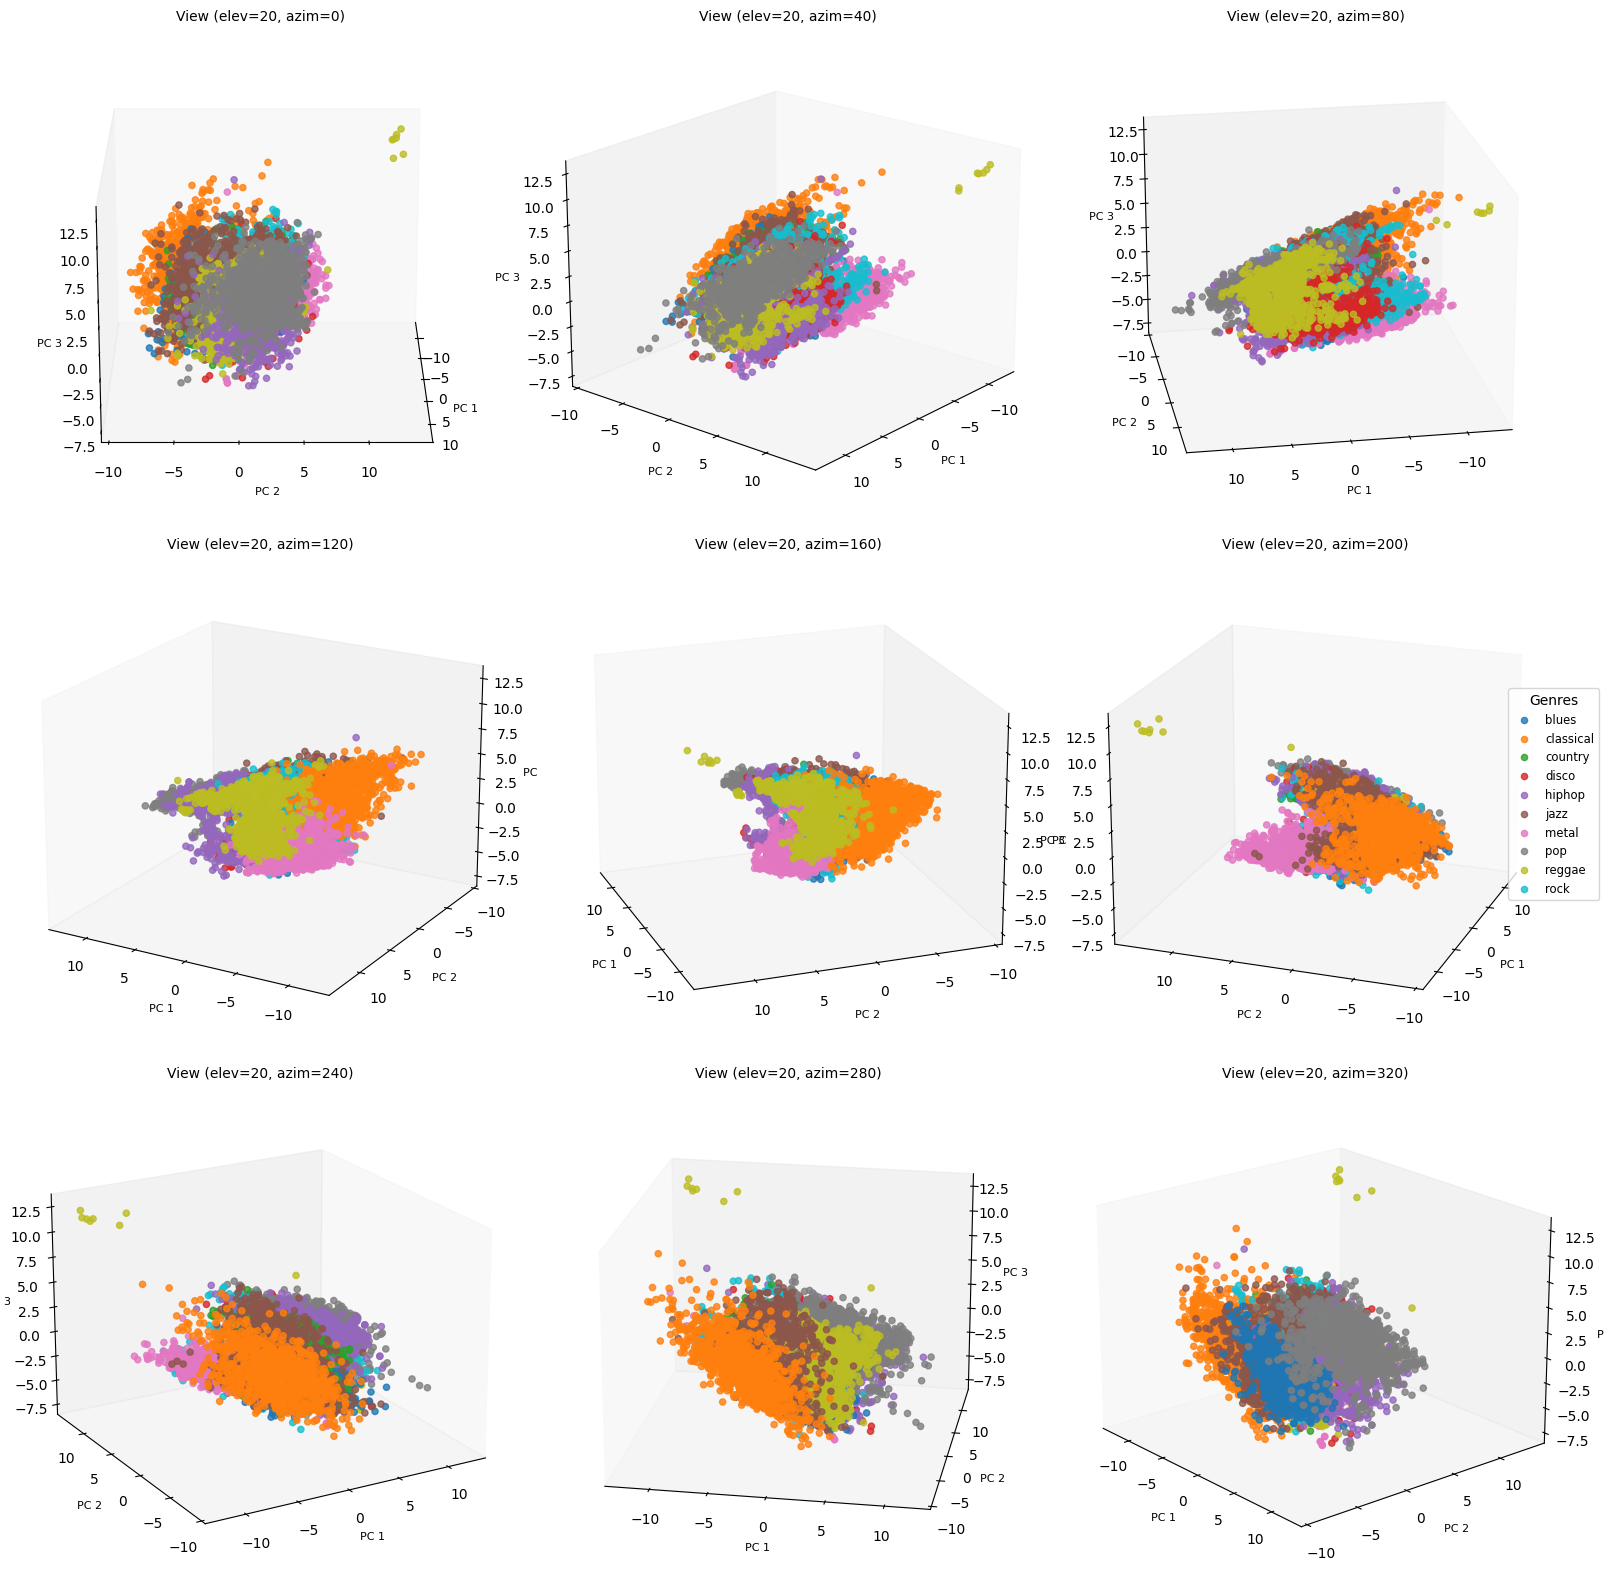

In [ ]:
# map encoded labels back to genre names
unique_labels = np.unique(y_encoded)
genre_names = label_encoder.inverse_transform(unique_labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))  # Distinct colors

fig = plt.figure(figsize=(16, 16))

# define multiple viewing angles (elevation and azimuth)
view_angles = [(20, azim) for azim in range(0, 360, 40)]  # 40° increments around azimuth

for i, (elev, azim) in enumerate(view_angles, start=1):
    ax = fig.add_subplot(3, 3, i, projection='3d')
    for genre, color, label in zip(unique_labels, colors, genre_names):
        mask = y_encoded == genre
        ax.scatter(
            X_lower_dim[mask, 0],
            X_lower_dim[mask, 1],
            X_lower_dim[mask, 2],
            label=label,
            color=[color],
            alpha=0.8
        )
    ax.set_title(f"View (elev={elev}, azim={azim})", fontsize=10)
    ax.set_xlabel("PC 1", fontsize=8)
    ax.set_ylabel("PC 2", fontsize=8)
    ax.set_zlabel("PC 3", fontsize=8)
    ax.view_init(elev=elev, azim=azim)
    ax.grid(False)

# add legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="Genres", loc="center right", fontsize="small")

plt.tight_layout()
plt.show()

# save image to drive
folder_path = '/content/gdrive/My Drive/ML Final Project/Figures'
file_name = 'gtzan_analysis_' + method + '_' + 'lower_dimensional_embeddings.png'

os.makedirs(folder_path, exist_ok=True)

file_path = os.path.join(folder_path, file_name)
fig.savefig(file_path)

In [ ]:
class KNNClassifier:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X):
        predictions = []
        for x in X:
            distances = np.linalg.norm(self.X_train - x, axis=1)
            neighbor_indices = np.argsort(distances)[:self.k]
            neighbor_labels = self.y_train[neighbor_indices]
            most_common = Counter(neighbor_labels).most_common(1)[0][0]
            predictions.append(most_common)
        return np.array(predictions)

    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

X_train, y_train = X_lower_dim, y_encoded  # Use lower dimension data


np.random.seed(100)

# shuffle and split data into train and test sets
indices = np.random.permutation(len(X_train))
train_size = int(0.8 * len(X_train))
train_indices, test_indices = indices[:train_size], indices[train_size:]

X_train_split, X_test_split = X_train[train_indices], X_train[test_indices]
y_train_split, y_test_split = y_train[train_indices], y_train[test_indices]

# create, train, and test the KNN model
knn = KNNClassifier(k=3)
knn.fit(X_train_split, y_train_split)

accuracy = knn.score(X_test_split, y_test_split)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.46


In [ ]:
X_train, y_train = X_lower_dim, y_encoded  # Use lower dimension data

np.random.seed(100)

# shuffle and split data into train and test sets
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=100)

# create, train, and test the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=100)
model.fit(X_train_split, y_train_split)

y_pred = model.predict(X_test_split)
accuracy = accuracy_score(y_test_split, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.51


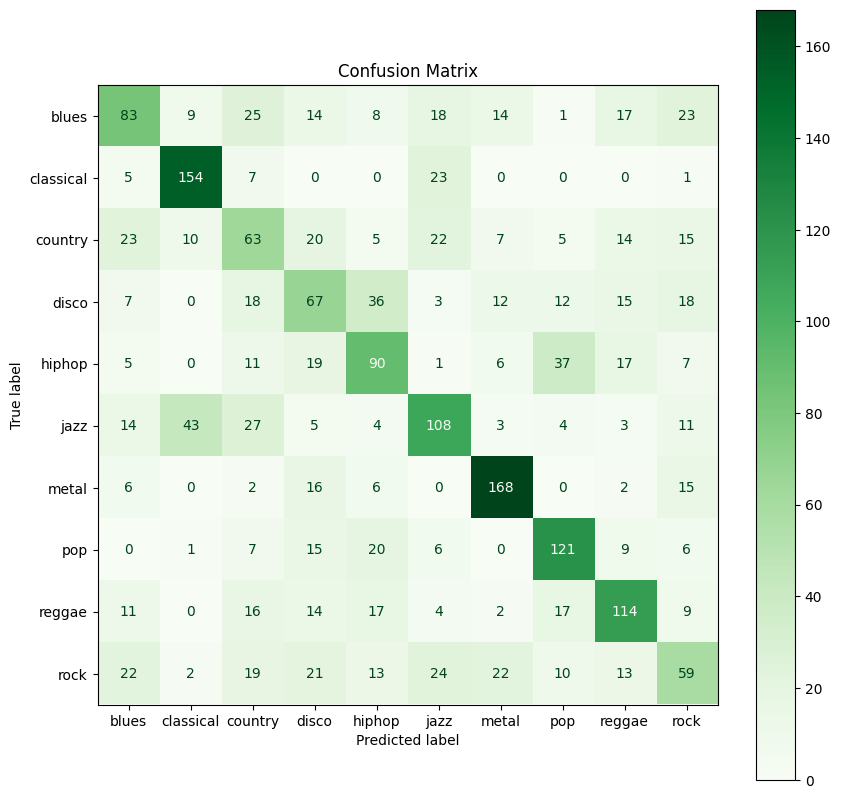

In [ ]:
cm = confusion_matrix(y_test_split, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap="Greens", colorbar=True)
plt.title("Confusion Matrix")
plt.show()

folder_path = '/content/gdrive/My Drive/ML Final Project/Figures'
file_name = 'gtzan_analysis_' + method + '_' + 'confusion_matrix.png'

os.makedirs(folder_path, exist_ok=True)

file_path = os.path.join(folder_path, file_name)
fig.savefig(file_path)